In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

import dill

rcParams['font.family'] = 'Arial'

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [3]:
with open(DATAFOLDER / "x_array_with_7clusters.pickle", "rb") as f:
    x_array = dill.load(f)

In [4]:
x_array

,id,condition,trial,infusiontype,cluster
0,PB23,deplete,0,10NaCl,1
1,PB23,deplete,1,10NaCl,3
2,PB23,deplete,2,10NaCl,1
3,PB23,deplete,3,10NaCl,1
4,PB23,deplete,4,10NaCl,3
...,...,...,...,...,...
475,PB75,replete,7,45NaCl,6
476,PB75,replete,8,45NaCl,3
477,PB75,replete,9,45NaCl,3
478,PB75,replete,10,45NaCl,3


In [5]:
with open(DATAFOLDER / "snips_data_selected_conditions_reduced.pickle", "rb") as f:
    data = dill.load(f)

snips_10NaCl = data["snips_10NaCl_reduced"]
snips_45NaCl = data["snips_45NaCl_reduced"]

snips_all = np.vstack([snips_10NaCl, snips_45NaCl])
snips_all.shape

(480, 200)

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6


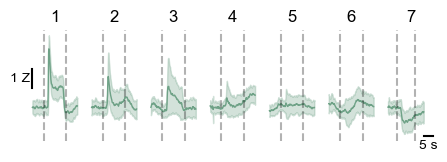

In [7]:
f, ax = plt.subplots(ncols=len(x_array.cluster.unique()), sharey=True, figsize=(4.5, 1.5),
                                          gridspec_kw={'left': 0.05, 'right': 0.95, 'top': 0.85}
                                          )

for cluster in np.arange(0,7):
    print("Cluster", cluster)
    snips_cluster = snips_all[x_array.cluster == cluster, :]
    x = np.arange(snips_cluster.shape[1]) / 10
    mean = np.mean(snips_cluster, axis=0)
    sem = np.std(snips_cluster, axis=0) / np.sqrt(snips_cluster.shape[0])
    sd = np.std(snips_cluster, axis=0)
    
    ax[cluster].plot(x, np.mean(snips_cluster, axis=0), color="#6FA287", lw=1)
    ax[cluster].fill_between(x, mean-sd, mean+sd, alpha=0.3, color="#6FA287")
    ax[cluster].set_title(f"{cluster+1}")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.axvline(5, color="k", linestyle="--", alpha=0.3)
    axis.axvline(15, color="k", linestyle="--", alpha=0.3)
    sns.despine(ax=axis, top=True, right=True, left=True, bottom=True)
    

ax[0].plot([0, 0], [1, 2], color="k")
ax[0].text(-1, 1.5, "1 Z", ha="right", va="center", fontsize=10)

ax[6].plot([20, 25], [-1.5, -1.5], color="k")
ax[6].text(22.5, -1.7, "5 s", ha="center", va="top", fontsize=10)

f.savefig(FIGSFOLDER / "snips_clusters.pdf", dpi=600, transparent=True)

In [86]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(data_for_stats)

# Output the results
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)



NameError: name 'data_for_stats' is not defined

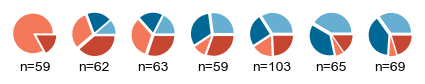

In [13]:
# order for data is rep_10, rep_45, dep_10, dep_45
 
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

f, ax = plt.subplots(ncols=len(x_array.cluster.unique()), figsize=(4.5, 0.8),
                     gridspec_kw={'left': 0.05, 'right': 0.95}
                     )

for cluster in np.arange(0,7):
    tmp = x_array.query("cluster == @cluster")# .groupby(["condition", "infusiontype"]).count().cluster
    total = len(tmp)
    pie_props = [len(tmp.query("condition == 'replete' & infusiontype == '10NaCl'")) / total,
                  len(tmp.query("condition == 'replete' & infusiontype == '45NaCl'")) / total,
                  len(tmp.query("condition == 'deplete' & infusiontype == '10NaCl'")) / total,
                  len(tmp.query("condition == 'deplete' & infusiontype == '45NaCl'")) / total]
    
    ax[cluster].pie(pie_props,
              colors=colors,
              explode=(0.1, 0.1, 0.1, 0.1),
              #autopct='%1.1f%%'
              )
    
    ax[cluster].text(0,-1.7, f"n={total}", ha="center", va="center", fontsize=10, color="k")

f.savefig(FIGSFOLDER / "pies_clusters.pdf", dpi=600, transparent=True)


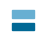

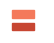

In [45]:
from matplotlib.patches import Rectangle, Patch

f, ax = plt.subplots(figsize=(0.35, 0.25), gridspec_kw={'left': 0.01, 'right': 0.99}
                    )
# for ref: groups = ["10NaCl replete", "45NaCl replete", "10NaCl deplete", "45NaCl deplete"]

groups = ["", ""]

legend_patches = []
for color, text in zip(colors[:2], groups):
    patch = Patch(color=color, label=text)  # Create a patch for the legend
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False,
          # bbox_to_anchor=(0.5, 0.5),
          # handletextpad=0.5,
          labelspacing=0.2,
          borderpad=0.05)
ax.axis('off')

f.savefig(FIGSFOLDER / "legend_pies_replete.pdf", dpi=600, transparent=True)


f, ax = plt.subplots(figsize=(0.35, 0.25), gridspec_kw={'left': 0.01, 'right': 0.99}
                     )

legend_patches = []
for color, text in zip(colors[2:], groups):
    patch = Patch(color=color, label=text)  # Create a patch for the legend
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False,
          # bbox_to_anchor=(0.5, 0.5),
          # handletextpad=0.5,
          labelspacing=0.2,
          borderpad=0.05)
ax.axis('off')

f.savefig(FIGSFOLDER / "legend_pies_deplete.pdf", dpi=600, transparent=True)

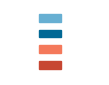

In [14]:
from matplotlib.patches import Rectangle, Patch

f, ax = plt.subplots(figsize=(1, 0.8), gridspec_kw={'left': 0.01, 'right': 0.90}
                    )

# for ref: groups = ["10NaCl replete", "45NaCl replete", "10NaCl deplete", "45NaCl deplete"]

groups = ["", "", "", ""]
legend_patches = []
for color, text in zip(colors, groups):
    patch = Patch(color=color, label=text)  # Create a patch for the legend
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False, bbox_to_anchor=(0.5, 0.5))

ax.axis('off')

f.savefig(FIGSFOLDER / "legend_pies.pdf", dpi=600, transparent=True)



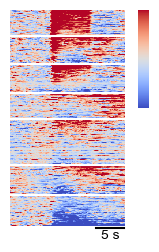

In [ ]:
# plot heatmap of all trials sorted first by cluster, then by strength of response using
# sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# or similar

list_of_clustered_snips = []
n_of_clusters = []

for cluster in np.arange(0,7):
    print("Cluster", cluster)
    tmp = snips_all[x_array.cluster == cluster, :]
    sort_order = np.argsort(np.mean(tmp[:,50:150], axis=1))[::-1]
    snips_cluster = tmp[sort_order, :]

    print(snips_cluster.shape)

    snips_cluster.shape
    list_of_clustered_snips.append(snips_cluster)
    n_of_clusters.append(snips_cluster.shape[0])
    
clustered_snips = np.vstack(list_of_clustered_snips)

f = plt.figure(figsize=(1.8, 2.8))
gs = f.add_gridspec(2, 2, width_ratios=[10, 1])  # Adjust width_ratios for colorbar width

# Add heatmap and colorbar axes
ax = f.add_subplot(gs[:, 0])
cbar_ax = f.add_subplot(gs[0, 1])

sns.heatmap(clustered_snips, ax=ax, vmin=-1, vmax=1, cmap="coolwarm", cbar_ax=cbar_ax)
ax.set_yticks([])
ax.set_xticks([])

for c in np.cumsum(n_of_clusters)[:-1]:
    ax.axhline(c, color="white")


ax.plot([150, 198], [485, 485], color="k", linewidth=1.5, clip_on=False)
ax.text(174, 490, "5 s", ha="center", va="top")

cbar_ax.set_yticks([])

f.savefig(FIGSFOLDER / "clusters_heatmap.pdf", dpi=600, transparent=True)




In [46]:
with open(DATAFOLDER / "x_array_with_2clusters.pickle", "rb") as f:
    x_array2 = dill.load(f)

In [47]:
df = x_array2

def get_prop_of_cluster(df, cluster, condition, infusiontype):
    df_temp = (df
               .query("condition == @condition & infusiontype == @infusiontype")
               )
               
    prop_by_trial = []

    for trial in df_temp.trial.unique():
        n = len(df_temp.query("trial == @trial"))
        n_cluster = len(df_temp.query("trial == @trial & cluster == @cluster"))
        prop_by_trial.append(n_cluster / n)
    
    return prop_by_trial

p = get_prop_of_cluster(df, 0, "replete", "45NaCl")

In [48]:
p

[0.2, 0.2, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0]

In [49]:
df

,id,condition,trial,infusiontype,cluster
0,PB23,deplete,0,10NaCl,0
1,PB23,deplete,1,10NaCl,1
2,PB23,deplete,2,10NaCl,0
3,PB23,deplete,3,10NaCl,0
4,PB23,deplete,4,10NaCl,0
...,...,...,...,...,...
475,PB75,replete,7,45NaCl,1
476,PB75,replete,8,45NaCl,1
477,PB75,replete,9,45NaCl,1
478,PB75,replete,10,45NaCl,1


Cluster 0
(138, 200)
Cluster 1
(342, 200)
Cluster 2
(0, 200)
Cluster 3
(0, 200)
Cluster 4
(0, 200)
Cluster 5
(0, 200)
Cluster 6
(0, 200)


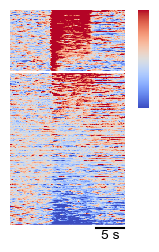

In [ ]:

list_of_clustered_snips = []
n_of_clusters = []

for cluster in np.arange(0,2):
    print("Cluster", cluster)
    tmp = snips_all[x_array2.cluster == cluster, :]
    sort_order = np.argsort(np.mean(tmp[:,50:150], axis=1))[::-1]
    snips_cluster = tmp[sort_order, :]

    print(snips_cluster.shape)

    snips_cluster.shape
    list_of_clustered_snips.append(snips_cluster)
    n_of_clusters.append(snips_cluster.shape[0])
    
clustered_snips = np.vstack(list_of_clustered_snips)

f = plt.figure(figsize=(1.8, 2.8))
gs = f.add_gridspec(2, 2, width_ratios=[10, 1])  # Adjust width_ratios for colorbar width

# Add heatmap and colorbar axes
ax = f.add_subplot(gs[:, 0])
cbar_ax = f.add_subplot(gs[0, 1])

sns.heatmap(clustered_snips, ax=ax, vmin=-1, vmax=1, cmap="coolwarm", cbar_ax=cbar_ax)
ax.set_yticks([])
ax.set_xticks([])

for c in np.cumsum(n_of_clusters)[:-1]:
    ax.axhline(c, color="white")


ax.plot([150, 198], [485, 485], color="k", linewidth=1.5, clip_on=False)
ax.text(174, 490, "5 s", ha="center", va="top")

cbar_ax.set_yticks([])

f.savefig(FIGSFOLDER / "2clusters_heatmap.pdf", dpi=600, transparent=True)

In [53]:
# make line plot with shaded error of cluster 1 and 2

In [ ]:
# make rep heatplots of two different rats over time - make for all rats and see who looks best
# try with original data and reduced data

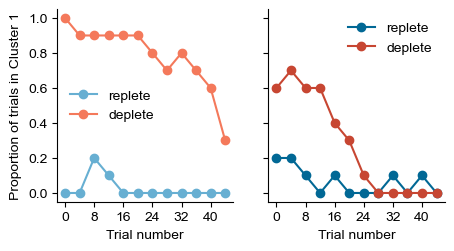

In [52]:
df = x_array2

f, ax = plt.subplots(ncols=2, figsize=(5, 2.5), sharey=True)

cluster=0
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

infusiontype = "10NaCl"
for condition, color in zip(["replete", "deplete"], [colors[0], colors[2]]):
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[0].plot(df_to_plot
                   #.rolling
                   , label=condition,
                   marker="o", color=color)
        
infusiontype = "45NaCl"
for condition, color in zip(["replete", "deplete"], [colors[1], colors[3]]):
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[1].plot(df_to_plot
                   #.rolling
                   , label=condition,
                   marker="o", color=color)


ax[0].set_ylabel("Proportion of trials in Cluster 1")

for axis in ax:
        axis.set_xlabel("Trial number")
        sns.despine(ax=axis)
        axis.set_xticks(np.arange(0, 12, 2),
                        labels=["0", "8", "16", "24", "32", "40"]
                        )
        axis.legend(frameon=False)
        #axis.set_ylim(0, 1)
        
        
        
f.savefig(FIGSFOLDER / "cluster_1_prop.pdf", dpi=600, transparent=True)

In [106]:
# code to work out how well the 2 clusters map on to the 7 clusters
x_array[x_array2.cluster == 0].groupby("cluster").count()

,id,condition,trial,infusiontype
cluster,,,,
0,59,59,59,59
1,40,40,40,40
2,20,20,20,20
3,8,8,8,8
4,9,9,9,9
6,2,2,2,2


In [107]:
x_array[x_array2.cluster == 1].groupby("cluster").count()

,id,condition,trial,infusiontype
cluster,,,,
1,22,22,22,22
2,43,43,43,43
3,51,51,51,51
4,94,94,94,94
5,65,65,65,65
6,67,67,67,67


0 0
Analyzing deplete 10NaCl
(7,)
0 1
Analyzing replete 10NaCl
(7,)
1 0
Analyzing deplete 45NaCl
(7,)
1 1
Analyzing replete 45NaCl
(7,)


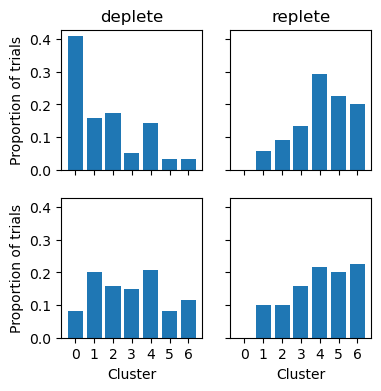

In [ ]:
infusiontype = "10NaCl"

df = x_array
n_clusters = len(df.cluster.unique())

f, ax = plt.subplots(ncols=2, nrows=2,
                     figsize=(4, 4),
                     sharey=True, sharex=True)
barx=np.arange(n_clusters)

for row, infusiontype in enumerate(df.infusiontype.unique()):
    for col, condition in enumerate(df.condition.unique()):
        print(row, col)
        print("Analyzing", condition, infusiontype)
        df_temp = df.query("condition == @condition & infusiontype == @infusiontype")
        data_to_plot = (df_temp
                        .groupby("cluster")
                        .count()
                        .reindex(range(0, 7), fill_value=0)  # Ensure clusters 1-7 are present
                        .infusiontype
                        .to_list()
        )
        data_to_plot_as_proportion = data_to_plot / np.sum(data_to_plot)
        print(data_to_plot_as_proportion.shape)
        ax[row,col].bar(barx, data_to_plot_as_proportion)
        # df_condition = df.query("condition == @condition")
        # df_condition = df_condition.sort_values("infusionrate")
        # #plt.plot(df_condition.infusionrate, df_condition.mean, label=condition)
        
    
ax[0,0].set_title("deplete")
ax[0,1].set_title("replete")

for axis in ax[1]:
    axis.set_xticks(barx)
    axis.set_xlabel("Cluster")
    
for axis in [ax[0,0], ax[1,0]]:
    axis.set_ylabel("Proportion of trials")

In [ ]:
def get_prop_over_time(df, infusiontype):
    df_temp = df.query("infusiontype == @infusiontype")
    props = []
    for cluster in df_temp.cluster.unique():
        df_cluster = df_temp.query("cluster == @cluster")
        prop = df_cluster.groupby("time").count().id
        props.append(prop)

    return props

p = get_prop_over_time(x_array.query("condition == 'deplete'"), "10NaCl")